# calculating return values and periods from pyextremes

In [2]:
import requests 
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

import pyextremes as pyext
from pyextremes.plotting import plot_extremes

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import climextremes

ModuleNotFoundError: No module named 'climextremes'

## extracting time series from netcdf file

In [6]:
ds = xr.open_dataset("./data/pr_Amon_NorESM1-M_historical_r1i1p1_185001-200512.nc")
print(ds)

<xarray.Dataset>
Dimensions:    (time: 1872, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/26)
    institution:            Norwegian Climate Centre
    institute_id:           NCC
    experiment_id:          historical
    source:                 NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Oslo-n...
    model_id:               NorESM1-M
    forcing:                GHG, SA, Oz, Sl, Vl, BC, OC
    ...                     ...
    table_id:               Table Amon (27 April 2011) a5a1c518f52ae340313ba0...
    title:                  NorESM1-M mo

In [7]:
# converting precipitation to m/day units

ds["pr"].data = ds["pr"].data * 86.4
ds["pr"].attrs["units"] = 'm/day' 

In [8]:
# setting defined location
# coordinates for berkeley, california

lat = 37.87
lon = 122.27

In [9]:
# getting dataset specifically for defined location

ds_berk = ds.sel(lon=lon, lat=lat, method='nearest')

In [10]:
ds_berk['pr'].values

array([0.00017749, 0.00060158, 0.00168481, ..., 0.00080042, 0.00033764,
       0.00064344], dtype=float32)

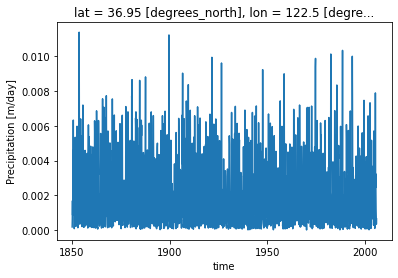

In [11]:
# plotting values for defined location

ds_berk['pr'].plot()

In [12]:
# converting to timeseries

series = ds_berk['pr'].to_pandas()

In [13]:
series.index = series.index.to_datetimeindex()

/var/folders/bz/l7frggbx71n9k19wxh7hvwsm0000gn/T/ipykernel_71459/2564721491.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  series.index = series.index.to_datetimeindex()


## use return period to get return value

### option 1

In [22]:
model = pyext.EVA(series)

In [16]:
model.get_extremes(method="BM", block_size="365.2425D")

In [17]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                               1,872
Start:                       January 1850      End:                        December 2005
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                156      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date-time', ylabel='extreme values'>)

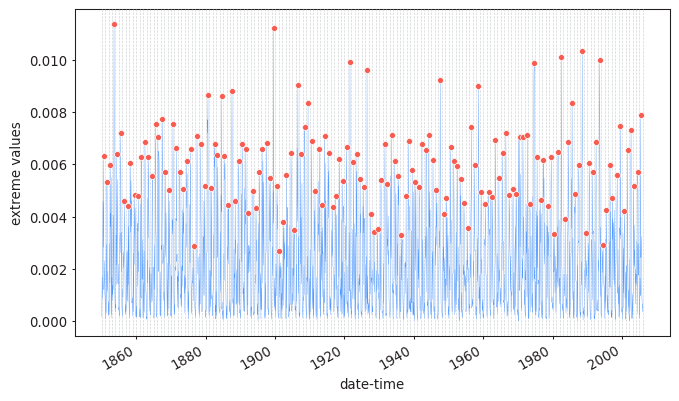

In [18]:
model.plot_extremes()

In [19]:
model.fit_model()

In [20]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)

/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [21]:
summary

,return value,lower ci,upper ci
return period,,,
1.0,-inf,NaN,NaN
2.0,0.005804,0.005568,0.006048
5.0,0.007401,0.007073,0.007745
10.0,0.008458,0.008036,0.008900
25.0,0.009794,0.009230,0.010355
50.0,0.010784,0.010117,0.011440
100.0,0.011768,0.010998,0.012512
250.0,0.013063,0.012136,0.013932
500.0,0.014041,0.013001,0.015007


### option 2

In [24]:
extremes = pyext.get_extremes(
    ts=series,
    method="BM",
    block_size="365.2425D",
)

In [32]:
x = np.array([0.014])

In [39]:
r = [0.006327]
x = pd.Series(r, copy=False)
x

0    0.006327
dtype: float64

In [42]:
return_periods = pyext.get_return_periods(
    ts=series,
    extremes=x,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
    return_period_size="365.2425D",
    plotting_position="weibull",
)

In [43]:
return_periods

,NaN,exceedance probability,return period
0,0.006327,0.5,2.0


In [38]:
return_periods

,extreme values,exceedance probability,return period
date-time,,,
1850-08-16 12:00:00,0.006327,0.407643,2.453125
1851-08-16 12:00:00,0.005336,0.643312,1.554455
1852-07-16 12:00:00,0.005973,0.515924,1.938272
1853-08-16 12:00:00,0.011385,0.006369,157.000000
1854-05-16 12:00:00,0.006396,0.388535,2.573770
...,...,...,...
2001-08-16 12:00:00,0.006570,0.343949,2.907407
2002-08-16 12:00:00,0.007323,0.152866,6.541667
2003-05-16 12:00:00,0.005163,0.668790,1.495238
